# A Gallery of Voice Transformers
<div align="right"><a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

In this notebook we will explore various ways to implement a system that changes the voice of a speaker. Typical applications for these techniques, strictly sorted by plausibility, include international spy missions and prank telephone calls, and devices such as the one displayed here can be easily bought on the web... or in a novelty shop.

<img width="250" style="float: left; margin: 10px 20px 0 0;" src="voice_changer.jpg">

More seriously, the goal is to describe a set of algorithms that allow us to modify a digital audio signal in ways that are increasingly more sophisticated  -- and increasingly more non-linear: a nice departure from the usual LTI signal processing paradigm! Also, our focus is on algorithms that can be implemented in efficiently and with minimal latency, so that we can use them to modify the voice of a speaker in real time; we will concentrate mainly on changing the pitch of a spoken utterance, which can be used to turn the speaker into a chipmunk or into Darth Vader. 

The focus on real-time implementation is brought to full fruition in a **freely available gitbook** that explains how to port some of the algorithms described here to an embedded **microcontroller** board. You can find the book [here](https://hwlab.learndsp.org/) and more information on the hardware setup in a [Coursera class](https://www.coursera.org/learn/dsp4/).

Let's start with some initial bookkeeping and let's define some helper functions that will be useful in the notebook:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from scipy.io import wavfile

In [2]:
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['image.cmap'] = 'tab10'

Although we are interested in a low-latency, real-time algorithm, in this notebook we will process a re-recorded sample speech file to illustrate the various techniques that we can implement. Let's load it and listen to it:

In [3]:
Fs, s = wavfile.read('speech.wav')
s = s / 32767.0 # scale the signal to floats in [-1, 1]
print('sampling rate: {}Hz'.format(Fs))
IPython.display.Audio(s, rate=Fs)

sampling rate: 16000Hz


Here's a simple helper function to convert milliseconds to samples:

In [4]:
def ms2smp(ms, Fs):
    return int(float(Fs) * float(ms) / 1000.0)

Let's also define a function to plot the magnitude spectrum of the speech signal (or of a portion thereof) with the labeling of the frequency axis in Hertz:

In [5]:
def plot_spec(x, Fs, max_freq=None, do_fft=True):
    C = int(len(x) / 2)  # positive frequencies only
    if max_freq:
        C = int(C * max_freq / float(Fs) * 2) 
    X = np.abs(np.fft.fft(x)[0:C]) if do_fft else x[0:C]
    N = Fs * np.arange(0, C) / len(x);
    plt.plot(N, X)
    return N, X

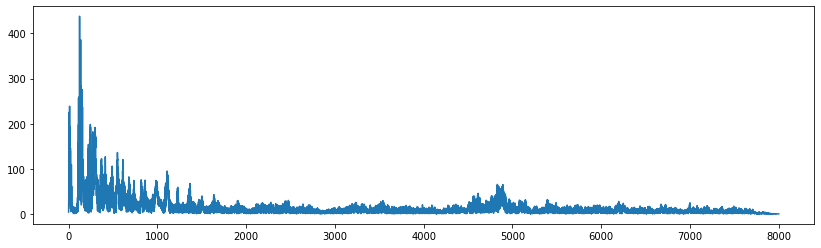

In [6]:
plot_spec(s, Fs, 8000);

## 1. The "Alien Voice"

The cheapest trick in the book to alter a person's voice is to use standard sinusoidal modulation to shift the voice spectrum up or down:

$$
    y[n] = x[n] \, \cos(\omega_0 n)
$$

A speech signal, as we can see from the plot above, is a baseband signal; since the modulation frequency must be kept small to preserve intelligibility, the spectrum of the modulated sequence will be severely affected by aliasing. Acoustically, this produces a lot of spurious non-harmonic frequencies and results in the "robotic" voice that can be heard in old, low-budget sci-fi movies:

In [7]:
def alien_voice(x, mod_freq, Fs):
    w = (float(mod_freq) / Fs) * 2 * np.pi  # normalized modulation frequency
    return 2 * np.multiply(x, np.cos(w * np.arange(0,len(x))))

IPython.display.Audio(alien_voice(s, 500, Fs), rate=Fs)

If we plot the spectrum of the modulated signal, we can immediately see the effect of aliasing in the two peaks at $500\pm100$Hz (where 100Hz is the approximate frequency of the peak in the original signal and 500Hz is the modulation frequency)

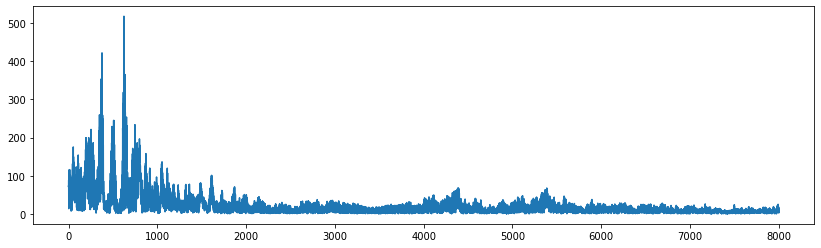

In [8]:
plot_spec(alien_voice(s, 500, Fs), Fs, 8000);

The only selling points for this voice transformer are related to its simplicity:
  * it works in real time with no delay (modulation is a memoryless operator)
  * it can be easily implemented in analog hardware
  
On the other hand, the end result is not particularly satisfying:
  * intelligibility is poor
  * harmonicity of voiced sounds is not preserved (the voice is "bell"-like)
  * there are a lot of artifacts, including a noticeable sinusoidal component at the modulation frequency (now you know why those cheap sci-fi movies had that constant hum in the background!)

We will revisit the last point in more detail in Section 4.

## 2. "Turntable" pitch shifting

<img width="200" style="float: right;" src="turntable.jpg"> While the alien voice effect can be used as a simple voice obfuscator, we will now consider the problem of changing the pitch of a voice signal to make it sound higher or lower but without the artefacts of sinusoidal modulation.
 
Let's first introduce a utility function to perform simple fractional resampling, since we will use this function a few times in the rest of the notebook. Given a discrete-time signal $x[n]$ and a real valued time index $N \le t < N+1$, the function returns the approximate value $x(t)$ as the _linear interpolation_ between $x[N]$ and $x[N+1]$ computed in $t-N$: 

In [9]:
def get_subsample(x, t):
    n = int(t)
    a = 1.0 - (t - n)
    try:
        return a * x[n] + (1 - a) * x[n + 1] 
    except IndexError:
        try:
            return a * x[n]
        except IndexError:
            return 0

With our subsample interpolator, it's now easy to perform a basic change of pitch for the speech signal; the result is equivalent to what we would obtain by spinning a record player faster or slower than the nominal RPM value of the record:

In [10]:
def resample(x, factor):
    # length of the output signal after resampling
    n_out = int(np.floor(len(x) / factor))
    y = np.zeros(n_out)
    for n in range(0, n_out):
        y[n] = get_subsample(x, float(n) * factor)
    return y

We can for instance lower the pitch, and obtain a "Darth Vader" voice:

In [11]:
IPython.display.Audio(resample(s, 0.6), rate=Fs)

or we can increase the pitch, and obtain a "Chipmunk" voice:

In [12]:
IPython.display.Audio(resample(s, 1.5), rate=Fs)

The obvious main problem with this approach, **which also makes it impossible to implement in real time,** is that the resampling changes the speed and the duration of the voice signal. In fact, we need to change the pitch without altering the time scale of the signal and therefore we need more sophisticated techniques.

## 3. Pitch shift via Granular Synthesis

The idea behind [Granular Synthesis](https://en.wikipedia.org/wiki/Granular_synthesis) (GS) is that complex waveforms can be built by stitching together very short sound snippets called "grains". By varying the content of the grains and by adjusting their rate, composers can generate complex timbres at arbitrary pitches. The psychoacoustic phenomenon underlying GS is that sound grains of short (but not too short) duration will be perceived as "pitched" events and they can therefore be joined together to create sustained waveforms. 

<img width="500" style="float: center;" src="gsplot.jpg">

### 3.1. Granular synthesis for time stretching

Granular synthesis allows us to easily stretch a signal in time _without affecting the pitch;_ all we need to do is to split the signal into small grains (around 30ms) and repeat each grain several times. For example, if we want to double the length of an audio clip, we can repeat each grain twice in a row:

In [13]:
def double_len(x, grain_size):
    N = len(x)
    y = np.zeros(2 * N)
    for n in range(0, len(x) - grain_size, grain_size):
        grain = x[n:n+grain_size]
        y[2*n:2*n+grain_size] = grain
        y[2*n+grain_size:2*n+2*grain_size] = grain
    return y

In [14]:
grain_size = ms2smp(30, Fs)
IPython.display.Audio(double_len(s, grain_size), rate=Fs)    

It works, although we encounter a classic audio artefact of block-based audio processing: when we double each block, we are introducing with high probability a large amplitude jump at the junction point between a grain and its copy, since the last and first sample of each grain may be very different. This generates a clicking sound as if we were adding a pulse train at half the grain rate. Here is proof: the audio file sounds very much like the disturbance in the double-length speech signal:

In [15]:
y = np.zeros(Fs * 2)
y[0:-1:2*grain_size] = 1
IPython.display.Audio(y, rate=Fs)

### 3.2. Crossfading

To mitigate this clicking noise we need to *crossfade* the grains. To do so, we employ a *tapered* window that smooths to zero the beginning and end of each grain. The following function returns a simple window shaped as an isosceles trapezoid. The overlap parameter $0 \le a \le 1$ determines the *total* amount of taper. The function also returns a stride value which can be used to shift the analysis window so that the tapered parts align exactly: 

In [16]:
def win_taper(N, overlap):
    R = int(N * overlap / 2)
    r = np.arange(0, R) / float(R)
    win = np.r_[r, np.ones(N - 2*R), r[::-1]]
    stride = N - R - 1
    return win, stride

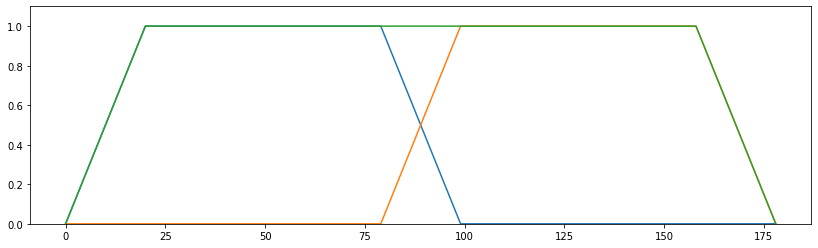

In [17]:
# generate a window with 40% taper (20% left and 20% right)
win, stride = win_taper(100, .4)
# align two windows using the given stride and sum them 
win1 = np.r_[win, np.zeros(stride)]
win2 = np.r_[np.zeros(stride), win]
plt.plot(win1);
plt.plot(win2);
# if the windows are properly aligned, the tapered areas compensate
plt.plot(win1 + win2);
plt.gca().set_ylim([0, 1.1]);

With this we can rewrite the function that doubles the audio length as such:

In [18]:
def double_len2(x, grain_size):
    N = len(x)
    y = np.zeros(2 * N)
    overlap = 0.4
    win, stride = win_taper(grain_size, overlap)
    ix = 0
    for n in range(0, len(x) - grain_size, grain_size):
        for k in [0, 1]:
            y[ix:ix+grain_size] += x[n:n+grain_size] * win
            ix += stride
    return y

and indeed things sounds better:

In [19]:
IPython.display.Audio(double_len2(s, ms2smp(30, Fs)), rate=Fs)  

### 3.3. From time stretching to pitch shifting

OK, so here's an idea: if we have managed to *double* the signal's length without changing the pitch, we could apply the "turntable" resampler to the twice-long signal and obtain a signal at twice the pitch but with the same length as the original! And indeed:

In [20]:
IPython.display.Audio(resample(double_len2(s, ms2smp(30, Fs)), 2), rate=Fs)

In fact, we can combine time stretching and resampling in a single opearation, by synthesizing the output via *resampled grains*. This leads to a simple pitch shifter that **works in real time** with just a small processing delay; also, the pitch shifter works for all frequency shift factors.

The principle behind granular pitch shifting is best understood graphically. Consider initially a fractional resampling function that, for each value of the *output* index $n$, returns the (potentially non-integer) index $i$ of the input signal that we have to use to produce the output: $i[n] = R(n, f)$; $f$ here is the resampling factor.

We can plot $i[n]$ for different values of $f$. When $f=1$, as in the first panel below, each output sample coincides with an input sample and $i[n] = n$, resulting in a 45-degree line. If we increase the speed, say $f=1.6$, we "use up" the input signal faster; this corresponds to the second panel, in which we run out of input samples in less than the length of the output. Finally, if we slow down the input, we only use a smaller number of input samples over the support of the output, as shown in the third panel.

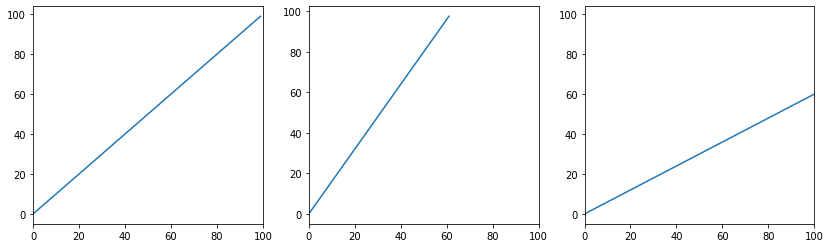

In [21]:
n = np.arange(0, 100)
for ix, f in enumerate([1, 1.6, 0.6]):
    plt.subplot(1, 3, ix+1)
    plt.plot(resample(n, f))
    plt.gca().set_xlim([0, 100])

In granular pitch shifting we generate output grains by performing fractional resampling on fixed-length input _chunks_; the start times for an input chunk and the corresponding output grain are synchronized but the number of input samples needed to produce the output grain will be larger or smaller than the size of the output grain according to whether we're raising or lowering the pitch. For instance, if the grain size is 100 samples and we are increasing the output frequency by 20%, we will need to use input chunks that are at least 120 samples long. To preserve the synchronicity of input and output, at the end of a grain generation process we will need to jump back in the input data by 20 samples. This way, the maximum buffer delay to produce a grain will be at most than $Gf$ samples, where $G$ is the size of the grain and $f$ is the resampling factor. 

Again, things are best illustrated graphically. The following function computes the index of the input signal for each output index value $n$ based on the resampling factor $f$ and a grain size $G$; note that, obviously, the index is non-integer so that the samples used in the grain are obtained via fractional resampling:

In [22]:
def gs_map(n, factor, grain_size):
    # beginning of grain
    t = np.floor(n / grain_size) * grain_size
    # fractional index in input grain
    t += (n - t) * factor
    return t

If we plot the input time index as a function of the output index we can see that we're traversing the input signal in a zig-zagging pattern; the slope of each segment is equal to $f$ as in the global resampler, but the input time index is pulled back or advanced appropriately to keep an average ratio of 1:1 between input and output:

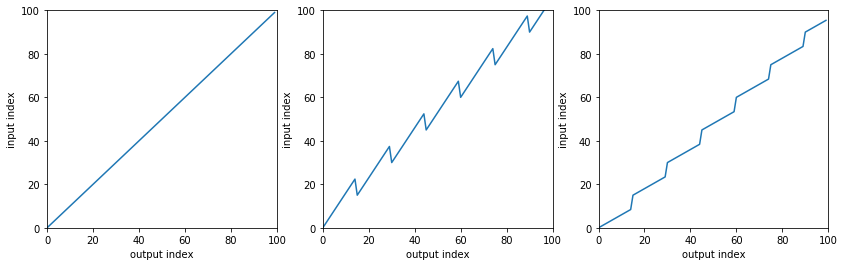

In [23]:
n = np.arange(0, 100)
for ix, f in enumerate([1, 1.6, 0.6]):
    plt.subplot(1, 3, ix+1)
    plt.plot(gs_map(n, f, 15))
    plt.gca().set_xlim([0, 100])
    plt.gca().set_ylim([0, 100])
    plt.xlabel('output index')    
    plt.ylabel('input index')

You can see that input and output indices "resynchronize" at the beginning of each grain (they touch the 45-degree slope). 

Note that in the above plots we are not using any overlap between grains. Of course in practice we are going to use overlapping grains with a tapering window, as in the following function:

In [24]:
def GS_pshift(x, factor, grain_size, overlap=0.5):
    N = len(x)
    y = np.zeros(N)
    # size of input buffer given target ouptut grain size and resampling factor
    input_chunk_size = int(grain_size * factor + 0.5)
    win, stride = win_taper(grain_size, overlap)
    for n in range(0, len(x) - max(input_chunk_size, grain_size), stride):
        w = resample(x[n:n+input_chunk_size], factor)
        y[n:n+grain_size] += w * win
    return y

Let's try it out on some audio; here comes the chipmunk:

In [25]:
IPython.display.Audio(GS_pshift(s, 1.5, ms2smp(40, Fs), .25), rate=Fs) 

and here is Darth Vader:

In [26]:
IPython.display.Audio(GS_pshift(s, 0.6, ms2smp(31, Fs), .25), rate=Fs) 

Although we have just described a purely digital version of grain-based pitch shifting, it is interesting to remark that, before digital audio was a reality, the only true pitch-shifting devices available to the music industry were extremely complex (and costly) mechanical devices that implemented, in analog, the same principle behind granular synthesis. <img width="400" style="float: left; margin-right: 30px;" src="pitchshift.jpg"> 

Here is the block diagram of such a contraption: the original sound is recorded on the main tape spool, which is run at a speed that can vary with respect to the nominal recording speed to raise or lower the pitch. To compensate for these changes in speed the tape head is actually a rotating disk containing four individual coils; at any given time, at least two neighboring coils are picking up the signal from the tape, with an automatic fade-in and fade-out as they approach and leave the tape. The head disk rotates at a speed that compensates for the change in speed of the main tape, therefore keeping the timebase constant. The coils on the head disk picking up the signal are in fact producing overlapping "grains" that are mixed together in the output signal.  

## 4. DFT-based pitch shift

The next pitch shifting technique that we will explore operates in the frequency domain. To set the stage, let's initially consider a simple pitched sound, i.e. a signal that appears, to the human ear, to have a discernible sustained pitch; this could be a vowel in a speech signal or a note played by a musical instrument. Spectrally, a pitched sound exhibits a *harmonic* structure, that is, as we scan the spectrum from left to right, we encounter a first clear spectral line (called the *fundamental*) followed by other peaks (called the *partials*) at exact multiples of the fundamental. The frequency of the fundamental is the perceived pitch of the sound and the regular pattern of spectral lines at precise multiples of the fundamental is what makes a pitched sound "natural" to the ear. 

Here is for instance an example of a (synthetic) clarinet note with pitch D4 (i.e. whose fundamental frequency is at 293.6 Hz). The spectrum shows the typical pattern of woodwinds, where only the even-numbered partials have significant energy.

In [27]:
Fs_y, y = wavfile.read('clarinet.wav')
IPython.display.Audio(y, rate=Fs_y)

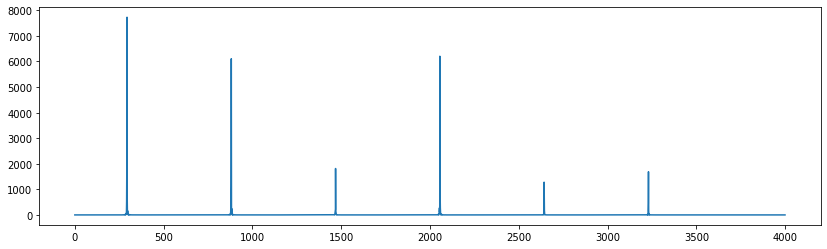

In [28]:
plot_spec(y, Fs_y, 4000);

<img width="140" style="float: right; margin: 0 30px 0 30px;" src="bell.jpg">If we now want to change the frequency content of a pitched sound without altering its duration, we could try to take a Fourier transform, move the frequencies around, and then invert the transform. As long as the Hermitial symmetry of the modified spectrum is preserved, we would obtain a real-valued time-domain signal. 

However, if we simply shift the spectrum up and down, we can move the position of the spectral lines but we will lose the harmonicity relation between the partials, which will no longer fall at multiples of the fundamental, and we will lose the naturalness of the sound (this is why the "robot voice" sounds weird).  Incidentally, the only "musical instrument" that produces non-harmonic spectra is the church bell, and that's why music played on bells sounds very strange.  

Let's quickly demonstrate what happens when the proportionality between partials is broken:

In [29]:
def DFT_translate(x, k):
    N = len(x)        
    X = np.fft.fft(x - np.mean(x))
    Y = np.r_[np.zeros(k), X[0:int(N/2-k)]]
    y = np.fft.ifft(np.r_[Y, np.conj(Y[-1:0:-1])])
    return np.real(y[0:N])

IPython.display.Audio(DFT_translate(y, 210), rate=Fs_y)

The proper way to change the pitch is, instead, to *stretch* (or compress) the frequency axis via a scaling factor, which preserves the proportionality relationship between the partials. 

Here is a function that does just that:

In [30]:
def DFT_rescale(x, factor):
    X = np.fft.fft(x)
    # separate even and odd lengths
    parity = (len(X) % 2 == 0)
    N = int(len(X) / 2) + 1 if parity else (len(X) + 1) / 2
    Y = np.zeros(N, dtype=np.complex)
    # work only in the first half of the DFT vector since input is real
    for n in range(0, N):
        # accumulate original frequency bins into rescaled bins
        ix = int(n * factor)
        if ix < N:
            Y[ix] += X[n]
    # now rebuild a Hermitian-symmetric DFT
    Y = np.r_[Y, np.conj(Y[-2:0:-1])] if parity else np.r_[Y, np.conj(Y[-1:0:-1])]
    return np.real(np.fft.ifft(Y))

We're now ready to try our pitch shifter:

In [31]:
IPython.display.Audio(DFT_rescale(y, 1.4), rate=Fs_y)

OK, it works, at least for sustained sounds.

However, if we want to apply the same approach to speech, we run into the problem that speech is a nonstationary signal where pitched sounds (the vowels) alternate with non-pitched sounds (the consonants). The ideal solution would be to segment the speech signal into portions that isolate individual sounds and then apply spectral shifting to the vowels. In practice, we can just try to segment the incoming signal into small chunks and apply spectral shifting to each chunk independently; applying pitch shifting to the unvoiced portions doesn't affect their nature much.

The length of the segments over which we compute (and shift) the DFT should be short enough to encompass a single pitched event but long enough to allow for a good resolution in the DFT. Usually, a window between 40 and 100 milliseconds is OK. Again, we will use a tapering window to minimize border effects in the result. 

In [32]:
def DFT_pshift(x, factor, chunk_size, overlap=0):
    N = len(x)
    y = np.zeros(N)
    win, stride = win_taper(chunk_size, overlap)
    for n in range(0, len(x) - chunk_size, stride):
        w = DFT_rescale(x[n:n+chunk_size] * win, factor)
        y[n:n+chunk_size] += w * win
    return y

Let's try the "Darth Vader" voice again: 

In [33]:
IPython.display.Audio(DFT_pshift(s, 0.6, ms2smp(40, Fs), 0.2), rate=Fs)

and now let's try to raise the pitch:

In [34]:
IPython.display.Audio(DFT_pshift(s, 1.5, ms2smp(40, Fs), 0.4), rate=Fs)

This pitch-shifting technique can be implemented in real time, with a processing delay equal to the size of the analysis window. Also, more advanced versions (such as commercial "auto-tune" applications) take great care to minimize the artifacts that you can still hear in this very simple version using way more sophisticated frame analysis. We won't pursue this approach here because, in all of the methods we have seen so far, we have neglected one fundamental aspect of voice manipulation, namely, **preserving the position of the formants.** This can only be achieved by doing a more sophisticated analysis of each speech segment. 

## 5. LPC and the Vocoder

Although the preceding methods yield increasingly acceptable ways to shift the pitch of a voice, they all produce slighty unnatural-sounding speech. The reason behind this lack of naturality is to be found in the particular inner structure of a speech signal. Although the spectral structure of the voiced part is indeed that of an harmonic sound, the distribution of energy across the partial happens to be *independent* of the fundamental frequency. When we perform pitch shifting and we scale the whole spectrum up or down we also move the overall envelope, which results in an unnatural-sounding voice. 

### 5.1. LPC analysis

Consider the spectrum below, corresponding to a short voiced speech segment (40ms); you can see the harmonic structure of the signal and, superimposed, you can see the overall energy envelope of the spectrum. If we want to change the pitch of this segment and still have it sound natural, we should make sure to keep the overall orange envelope in place. 

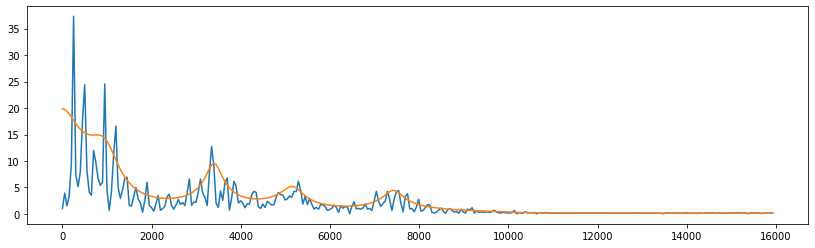

In [35]:
Fs_y, y = wavfile.read('voiced.wav')
y = y / 32767.0 # cast to floats in [-1, 1]
plot_spec(y, Fs_y)
Y = np.fft.fft([1.0, -2.1793, 2.4140, -1.6790, 0.3626, 0.5618, -0.7047, 
                0.1956, 0.1872, -0.2878, 0.2354, -0.0577, -0.0815, 0.0946, 
                0.1242, -0.1360, 0.0677, -0.0622, -0.0306, 0.0430, -0.0169], len(y))
plot_spec(np.abs(np.divide(1.0, Y)), Fs_y, do_fft=False);

The common model for the speech production mechanism is that of a source followed by a resonator. The source can be a pitched sound produced by the vocal cords, or a noise-like excitation produced by a flow of air; the resonator is the transfer function of the speech apparatus (mouth and head), which is independent of the source. Think of when you whisper: you are replacing the pitched excitation with air "noise" but you preserve the resonances of normal speech. A schematic view of the model is shown on the right.

<img width="400" style="float: right; margin-right: 30px;" src="lpc.jpg"> 

Mathematically we can express the production mechanism (in the $z$-domain) as $X(z) = A(z)E(z)$ where $E(z)$ is the excitation and $A(z)$ the resonance transfer function. Of course, in a spoken sentence, both $A(z)$ and $E(z)$ vary over time, but let's assume we have segmented the speech signal and we're operating over a stationary portion of the utterance. Our job is to estimate $A(z)$, i.e., the green overall envelope in the spectrum above; unfortunately, however, both $A(z)$ and $E(z)$ are unknown, so we need to massage the problem a bit. 

Experimentally, first of all, it turns out that the resonance transfer function can be described very well by an all-pole model (with poles inducing peaks in the spectral envelope):

$$
	A(z) = \frac{1}{1 - \sum_{k=1}^{p}a_kz^{-k}};
$$ 

with this representation we can rewrite the estimation problem in the time domain as

$$
	x[n] = \sum_{k=1}^{p}a_k x[n-k] + e[n]
$$

which becomes

$$
	e[n] = x[n] - \sum_{k=1}^{p}a_k x[n-k]
$$

The above equation is identical to the expression for the prediction error in a standard **AR linear prediction** problem. In those cases, the canonical approach to find the optimal coefficients for the all-pole filter is to *minimize the second moment (i.e. the energy) of the error*, that is, minimize $E[e^2[n]]$. In order to understand why this is a good criterion consider that, when the energy of the error is minimized, [the error is orthogonal to the input](https://en.wikipedia.org/wiki/Orthogonality_principle). In our speech analysis setup, what we call "error" is in fact the excitation source; the optimal coefficients will therefore give us a filter that, when used on the input, produces a signal that is orthogonal (i.e. maximally different) to the excitation. In other words, the optimal filter captures all the information that is *not* in the excitation.

The coefficients of the filter $A(z)$ are called the **linear prediction coding (LPC)** coefficients. There are a lot of good references on the web both on the theory of LPC (for example [here](https://ccrma.stanford.edu/~hskim08/lpc/)) and on good numerical LPC algorithms (see for instance [here](https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-341-discrete-time-signal-processing-fall-2005/lecture-notes/lec13.pdf)); without going through the derivation, suffice it to say that the coefficients are determined by solving the following system of equations

$$
    \begin{bmatrix}
        r_0 & r_1 & r_2 & \ldots & r_{p-1} \\
        r_1 & r_0 & r_1 & \ldots & r_{p-2} \\        
        & & & \vdots \\
        r_{p-1} & r_{p-2} & r_{p-3} & \ldots & r_{0} \\
    \end{bmatrix}
    \begin{bmatrix}
        a_1 \\
        a_2 \\        
        \vdots \\
        a_{p}
    \end{bmatrix} = 
    \begin{bmatrix}
        r_1 \\
        r_2 \\        
        \vdots \\
        r_{p}
    \end{bmatrix}
$$

where $r$ is the biased autocorrelation of the $N$-point input data:

$$
    r_m = (1/N)\sum_{k = 0}^{N-m-1}x[k]x[k+m]
$$

Because of the Toeplitz structure of the autocorrelation matrix, the system of equations can be solved very efficiently using the Levinson-Durbin algorithm. Here is a direct implementation of the method:

In [36]:
def bac(x, p):
    # compute the biased autocorrelation for x up to lag p
    L = len(x)
    r = np.zeros(p+1)
    for m in range(0, p+1):
        for n in range(0, L-m):
            r[m] += x[n] * x[n+m]
        r[m] /= float(L)
    return r

In [37]:
def ld(r, p):
    # solve the toeplitz system using the Levinson-Durbin algorithm
    g = r[1] / r[0]
    a = np.array([g])
    v = (1. - g * g) * r[0];
    for i in range(1, p):
        g = (r[i+1] - np.dot(a, r[1:i+1])) / v
        a = np.r_[ g,  a - g * a[i-1::-1] ]
        v *= 1. - g*g
    # return the coefficients of the A(z) filter
    return np.r_[1, -a[::-1]]     

In [38]:
def lpc(x, p):
    # compute p LPC coefficients for a speech segment
    return ld(bac(x, p), p)

Now that we have the LPC function in place, we can re-plot the initial spectrum with the overall envelope using an explicit computation:

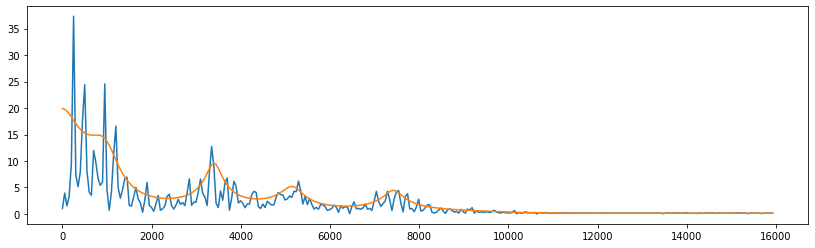

In [39]:
plot_spec(y, Fs_y)
A = np.fft.fft(lpc(y, 20), len(y))
plot_spec(np.abs(np.divide(1.0, A)), Fs_y, do_fft=False);

### 5.2. LPC-based pitch shifting

Back to pitch shifting problem: in order to properly pitch-shift a speech signal we will segment the input in small chunks with a certain amount of overlap and perform the following operations on each piece:

 1. compute the LPC coefficients for the speech in the chunk
 1. inverse-filter the chunk and recover the excitation signal
 1. pitch-shift the excitation
 1. forward-filter the shifted excitation to re-apply the formants' envelope.
 1. combine the processed chunks using a tapered window

In theory, we should determine whether the excitation signal for a segment is harmonic or not and apply pitch shfting only in the former case. For simplicity, we will just process all segments as if they were voiced, at the price of a little loss of quality.
 
To pitch-shift the excitation we can use either the DFT scaling method or the Granular Synthesis method. Below are the functions for both methods:

In [40]:
def LPC_DFT_pshift(x, factor, chunk_size, overlap=0.2, LPC_order=20):
    N = len(x)
    y = np.zeros(N)
    win, stride = win_taper(chunk_size, overlap)
    for n in range(0, len(x) - chunk_size, stride):
        chunk = x[n:n+chunk_size]
        a = lpc(chunk, LPC_order)
        exc = sp.lfilter(a, [1], chunk)
        exc = DFT_rescale(exc, factor)
        chunk = sp.lfilter([1], a, exc)
        y[n:n+chunk_size] += chunk * win
    return y    

In [41]:
IPython.display.Audio(LPC_DFT_pshift(s, 0.6, ms2smp(40, Fs)), rate=Fs)

In [42]:
IPython.display.Audio(LPC_DFT_pshift(s, 1.5, ms2smp(40, Fs)), rate=Fs)

Let's try the same, but with granular pitch shifting; it's actually simpler to implement (no FFT is required) and it sounds better!

In [43]:
def LPC_GS_pshift(x, factor, grain_size, overlap=0.2, LPC_order=20):
    N = len(x)
    y = np.zeros(N)
    # input chunk size will be dependent on grain_size and shifting factor
    chunk_size = int(grain_size * factor + 0.5)
    win, stride = win_taper(grain_size, overlap)
    for n in range(0, len(x) - max(chunk_size, grain_size), stride):
        chunk = x[n:n+chunk_size]
        a = lpc(chunk, LPC_order)
        exc = sp.lfilter(a, [1], chunk)
        # this changes the length of exc from chunk_size to grain_size:
        exc = resample(exc, factor)
        grain = sp.lfilter([1], a, exc)
        y[n:n+grain_size] += grain * win
    return y

In [44]:
IPython.display.Audio(LPC_GS_pshift(s, 0.6, ms2smp(40, Fs)), rate=Fs)

In [45]:
IPython.display.Audio(LPC_GS_pshift(s, 1.5, ms2smp(40, Fs), overlap=0.3), rate=Fs)

### 5.3 A simple vocoder

The LPC analysis can also be used to produce extremely artificial-sounding voices, as demonstrated here, where we replace the excitation siganl by a square wave of constant frequency. This is the type of sound created by the early [Vocoder](https://en.wikipedia.org/wiki/Vocoder) machines, for instance, and is still in use today to achieve some characteristic effects in popular music.

In [46]:
def LPC_daft(x, exc_pitch, chunk_size, Fs, overlap=0.2, LPC_order=20):
    omega = (float(exc_pitch) / Fs) * 2 * np.pi  
    exc = np.sign(np.cos(omega * np.arange(0, chunk_size)))
    N = len(x)
    y = np.zeros(N)
    win, stride = win_taper(chunk_size, overlap)
    for n in range(0, len(x) - chunk_size, stride):
        a = lpc(x[n:n+chunk_size], LPC_order)
        out_chunk = sp.lfilter([1], a, exc)
        y[n:n+chunk_size] += out_chunk * win
    return y    

In [47]:
IPython.display.Audio(LPC_daft(s, 140, ms2smp(40, Fs), Fs), rate=Fs)